In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import pytorch_lightning as pl
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import transforms

from src.data import PlethoraDataModule, Covid19DataModule, Covid19Dataset
from src.data.preprocess import *
from src.models.unet import UNet
from src.visualization import plot_batch, plot_true_vs_pred
from src.metrics import dice_coeff_vectorized

In [3]:
data_module_args = {                                                                                                                                              
   "batch_size": 16,
   "img_size": 512,
   "clip_low": -1000,
   "clip_high": 1000,
   "pin_memory": True,
   "num_workers": 4
}                                                                                                                                                                  dm = Covid19DataModule(**data_module_args)        
dm.setup()
print("No. test samples:", len(dm.test_ds))
test_loader = dm.test_dataloader()

No. test samples: 3520


In [9]:
# ignore normalized ct scans
ct_ids = os.listdir("data/raw/COVID-19-CT-Seg_20cases/ct_scans/")
ct_ids = sorted([os.path.basename(ct_id).split(".")[0] for ct_id in ct_ids])
ct_ids = [ct_id for ct_id in ct_ids if ct_id.find("radio") == -1]

ds = Covid19Dataset(ct_dir="data/raw/COVID-19-CT-Seg_20cases/ct_scans/",
                    mask_dir="data/raw/COVID-19-CT-Seg_20cases/lung_masks/",
                    ct_ids=ct_ids,
                    transform=dm.transform)
test_loader = DataLoader(ds, batch_size=16, pin_memory=True, shuffle=False)
len(ds)

2581

In [10]:
ds.metadata["ct_id"].unique()

array(['coronacases_001', 'coronacases_002', 'coronacases_003',
       'coronacases_004', 'coronacases_005', 'coronacases_006',
       'coronacases_007', 'coronacases_008', 'coronacases_009',
       'coronacases_010'], dtype=object)

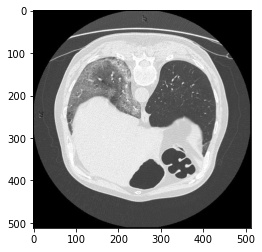

In [22]:
sample = ds[36]
img, mask = sample['img'], sample['mask']
plt.imshow(img.squeeze(), cmap='gray')

In [11]:
device = "cuda:0"
from src.models.unet import UNet
net = UNet.load_from_checkpoint("logs/unet-plethora-512/version_0/ckpts/epoch=8-dice_coeff_val=0.942.ckpt")
net.to(device).eval();

In [13]:
# sanity check model predictions
it = iter(test_loader)
#for _ in range(8):
#    batch = next(it)
# batch['img'] = batch['img'][:4]
# batch['mask'] = batch['mask'][:4]
with torch.no_grad():
    logits = net(batch['img'].to(device))
    pred_masks = torch.argmax(logits, dim=1)

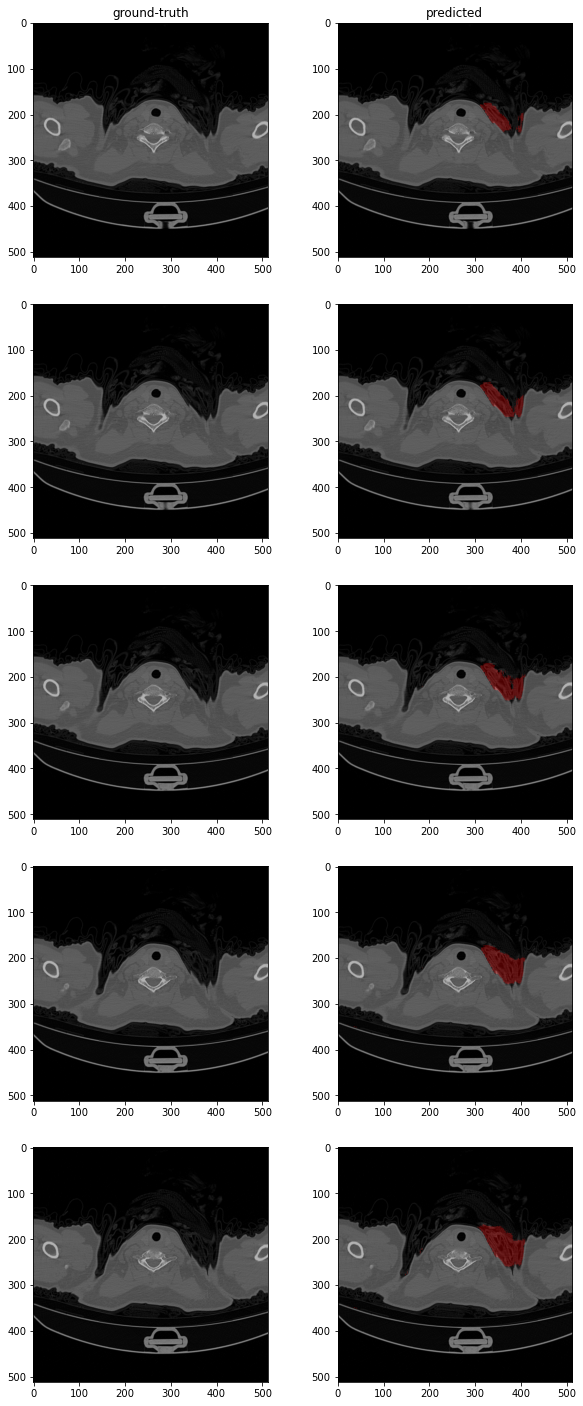

In [17]:
plot_true_vs_pred(batch['img'], 
                  batch['mask'], 
                  pred_masks.cpu(), mask_alpha=0.3)

In [15]:
dice_scores = []
#pbar = tqdm(dm.test_dataloader())
pbar = tqdm(test_loader)
# evaluate on test set
for batch in pbar:
    X, y = batch["img"].to(device), batch["mask"].to(device)
    with torch.no_grad():
        logits = net(X.to(device))
        pred_masks = torch.argmax(logits, dim=1)
        batch_dsc = dice_coeff_vectorized(pred_masks, y, reduce_fn=None)
        dice_scores.append(batch_dsc)
        pbar.set_description(f"dsc={batch_dsc.mean().item():.3f}")
dice_scores = torch.cat(dice_scores)

dsc=0.000: 100%|██████████| 162/162 [07:29<00:00,  2.78s/it]


In [16]:
print("dsc mean:", dice_scores.mean().item())

worst_idxs = torch.argsort(dice_scores, descending=False).cpu()
worst_idxs = worst_idxs[:500].numpy()
worst_idxs = np.random.choice(worst_idxs, size=10, replace=False)
dice_scores[worst_idxs]

dsc mean: 0.89993816614151


tensor([1.0204e-06, 9.4477e-01, 4.7664e-08, 5.3476e-07, 9.4619e-01, 9.3159e-01,
        9.3227e-01, 4.0000e-06, 9.3072e-01, 9.4297e-01], device='cuda:0')

In [9]:
plethora_dm = PlethoraDataModule(**data_module_args)
plethora_dm.setup()
plethora_ds = plethora_dm.test_dataloader()

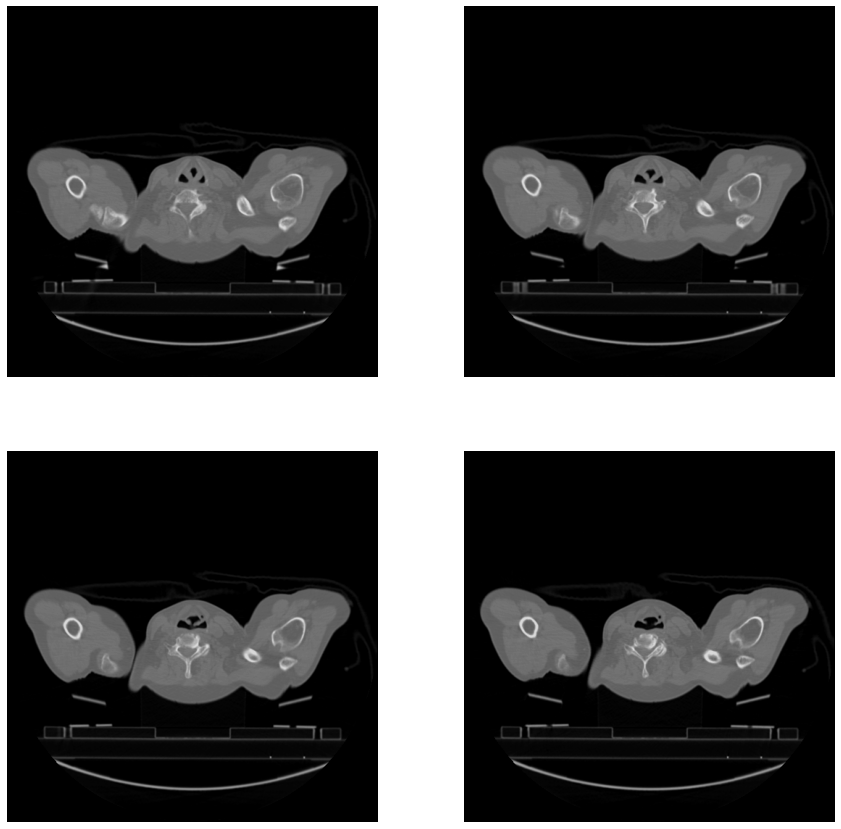

In [12]:
it = iter(plethora_ds)
for i in range(9):
    batch = next(it)
plot_batch(batch['img'][:4], batch['mask'][:4], 
           nrows=2, ncols=2)